# Brain tumor 3D segmentation with MONAI

## Setup environment

## Setup imports

In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.handlers.utils import from_engine
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
# from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    Invertd,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

## Setup data directory

In [2]:
set_determinism(seed=0)
root_dir = '../DecathlonDataset'
batch_size = 4

## Define a new transform to convert brain tumor labels

Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [3]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(torch.logical_or(torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1))
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, axis=0).float()
        return d

## Setup transforms for training and validation

In [4]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[240, 224, 144], random_size=False),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
        
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
    ]
)

## Quickly load data with DecathlonDataset

Here we use `DecathlonDataset` to automatically download and extract the dataset.
It inherits MONAI `CacheDataset`, if you want to use less memory, you can set `cache_num=N` to cache N items for training and use the default args to cache all the items for validation, it depends on your memory size.

In [5]:
# here we don't cache any data in case out of memory issue
train_ds = DecathlonDataset(
    root_dir="../DecathlonDataset",
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=False,
    cache_rate=0.0
)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DecathlonDataset(
    root_dir="../DecathlonDataset",
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=0.0
)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


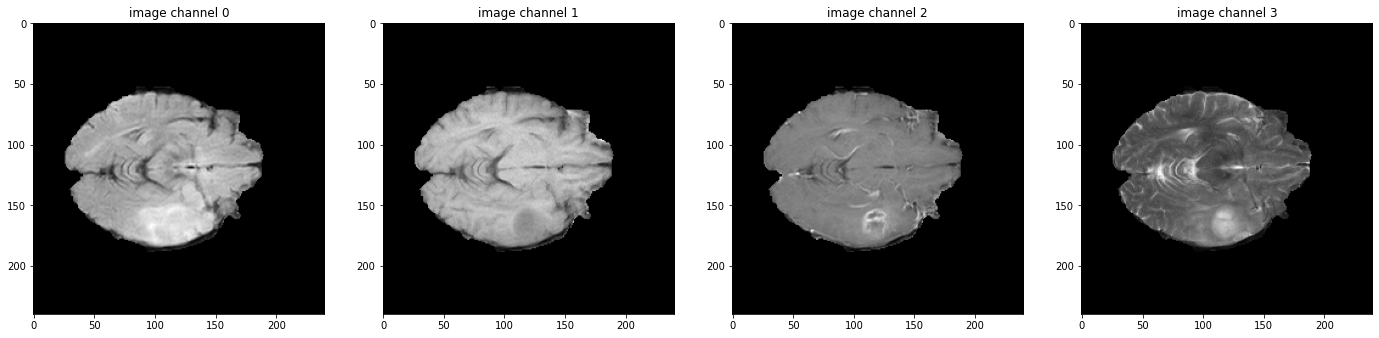

In [6]:
#pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()


label shape: torch.Size([3, 240, 240, 155])


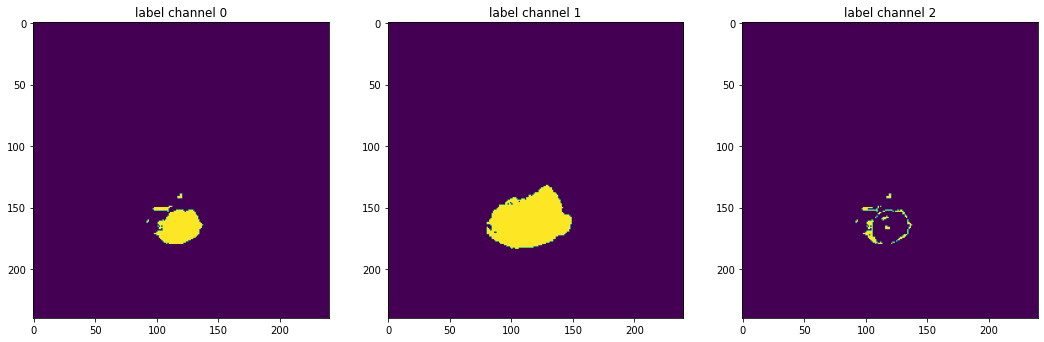

In [7]:
# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

## Create Model, Loss, Optimizer

In [8]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.input_layer = torch.nn.Conv3d(in_channels=4, out_channels=8, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        
        self.encoder_layer_1_1 = torch.nn.Conv3d(in_channels=8,  out_channels=8, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_1_1 = torch.nn.BatchNorm3d(8)
        self.encoder_layer_1_2 = torch.nn.Conv3d(in_channels=8, out_channels=8, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_1_2 = torch.nn.BatchNorm3d(8)
        self.encoder_layer_1_3 = torch.nn.Conv3d(in_channels=8, out_channels= 16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.maxpool_1 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_2_1 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_2_1 = torch.nn.BatchNorm3d(16)
        self.encoder_layer_2_2 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_2_2 = torch.nn.BatchNorm3d(16)
        self.encoder_layer_2_3 = torch.nn.Conv3d(in_channels=16, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.maxpool_2 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_3_1 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_3_1 = torch.nn.BatchNorm3d(32)
        self.encoder_layer_3_2 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_3_2 = torch.nn.BatchNorm3d(32)
        self.encoder_layer_3_3 = torch.nn.Conv3d(in_channels=32, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.maxpool_3 = torch.nn.MaxPool3d((2,2,2))

        self.encoder_layer_4_1 = torch.nn.Conv3d(in_channels=64, out_channels=128, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_4_1 = torch.nn.BatchNorm3d(128)
        self.encoder_layer_4_2 = torch.nn.Conv3d(in_channels=128, out_channels=128, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.encoder_batch_norm_4_2 = torch.nn.BatchNorm3d(128)

        self.upsample_3 = torch.nn.ConvTranspose3d(in_channels=128, out_channels=64, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_3_1 = torch.nn.Conv3d(in_channels=128, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_3_1 = torch.nn.BatchNorm3d(64)
        self.decoder_layer_3_2 = torch.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_3_2 = torch.nn.BatchNorm3d(64)
        self.decoder_layer_3_3 = torch.nn.Conv3d(in_channels=64, out_channels=64, kernel_size=(3,3,3), padding=(1,1,1), bias=False)

        self.upsample_2 = torch.nn.ConvTranspose3d(in_channels=64, out_channels=32, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_2_1 = torch.nn.Conv3d(in_channels=64, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_2_1 = torch.nn.BatchNorm3d(32)
        self.decoder_layer_2_2 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_2_2 = torch.nn.BatchNorm3d(32)
        self.decoder_layer_2_3 = torch.nn.Conv3d(in_channels=32, out_channels=32, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        
        self.upsample_1 = torch.nn.ConvTranspose3d(in_channels=32, out_channels=16, kernel_size=(2,2,2), stride=(2,2,2))
        self.decoder_layer_1_1 = torch.nn.Conv3d(in_channels=32, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_1_1 = torch.nn.BatchNorm3d(16)
        self.decoder_layer_1_2 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)
        self.decoder_batch_norm_1_2 = torch.nn.BatchNorm3d(16)
        self.decoder_layer_1_3 = torch.nn.Conv3d(in_channels=16, out_channels=16, kernel_size=(3,3,3), padding=(1,1,1), bias=False)

        self.output_layer = torch.nn.Conv3d(in_channels=16, out_channels=3, kernel_size=(1,1,1), bias=False)
 
    def forward(self, x):

        x = self.input_layer(x)

        x = self.encoder_layer_1_1(x)
        x = self.encoder_batch_norm_1_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_batch_norm_1_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_1_3(x))
        layer_1_head = x
        # print("1 ",x.shape)
        x = self.maxpool_1(x)

        x = self.encoder_layer_2_1(x)
        x = self.encoder_batch_norm_2_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_2_2(x)
        x = self.encoder_batch_norm_2_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_2_3(x))
        layer_2_head = x
        # print("2 ",x.shape)
        x = self.maxpool_2(x)

        x = self.encoder_layer_3_1(x)
        x = self.encoder_batch_norm_3_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_3_2(x)
        x = self.encoder_batch_norm_3_2(x)
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.relu(self.encoder_layer_3_3(x))
        layer_3_head = x
        # print("3 ",x.shape)
        x = self.maxpool_3(x)

        x = self.encoder_layer_4_1(x)
        x = self.encoder_batch_norm_4_1(x)
        x = torch.nn.functional.relu(x)
        x = self.encoder_layer_4_2(x)
        x = self.encoder_batch_norm_4_2(x)
        x = torch.nn.functional.relu(x)

        x = self.upsample_3(x)
        layer_3_tail = x
        x = torch.concat((layer_3_head, layer_3_tail), dim =1)
        # print("con3 ",x.shape)
        x = self.decoder_layer_3_1(x)
        x = self.decoder_batch_norm_3_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_3_2(x)
        x = self.decoder_batch_norm_3_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_3_3(x)
        x = torch.nn.functional.relu(x)
        
        x = self.upsample_2(x)
        layer_2_tail = x
        x = torch.concat((layer_2_head, layer_2_tail), dim=1)
        # print("con2 ",x.shape)
        x = self.decoder_layer_2_1(x)
        x = self.decoder_batch_norm_2_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_2_2(x)
        x = self.decoder_batch_norm_2_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_2_3(x)
        x = torch.nn.functional.relu(x)

        x = self.upsample_1(x)
        layer_1_tail = x
        x = torch.concat((layer_1_head, layer_1_tail), dim=1)
        # print("con1 ",x.shape)
        x = self.decoder_layer_1_1(x)
        x = self.decoder_batch_norm_1_1(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_1_2(x)
        x = self.decoder_batch_norm_1_2(x)
        x = torch.nn.functional.relu(x)
        x = self.decoder_layer_1_3(x)
        x = torch.nn.functional.relu(x)

        output = self.output_layer(x)

        return output

In [9]:
class Discriminator(torch.nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()

        self.layer_1_conv = torch.nn.Conv3d(in_channels=3,  out_channels=6, kernel_size=(3,3,3), padding=(1,1,1))
        self.batch_norm_1 = torch.nn.BatchNorm3d(6)
        self.maxpool_1 = torch.nn.MaxPool3d((2,2,2))

        self.layer_2_conv = torch.nn.Conv3d(in_channels=6, out_channels=9, kernel_size=(3,3,3), padding=(1,1,1))
        self.batch_norm_2 = torch.nn.BatchNorm3d(9)
        self.maxpool_2 = torch.nn.MaxPool3d((2,2,2))

        self.layer_3_conv = torch.nn.Conv3d(in_channels=9, out_channels=12, kernel_size=(3,3,3), padding=(1,1,1))
        self.batch_norm_3 = torch.nn.BatchNorm3d(12)
        self.maxpool_3 = torch.nn.MaxPool3d((2,2,2))

        self.layer_4_conv = torch.nn.Conv3d(in_channels=12, out_channels=15, kernel_size=(3,3,3), padding=(1,1,1))
        self.batch_norm_4 = torch.nn.BatchNorm3d(15)
        self.maxpool_4 = torch.nn.MaxPool3d((2,2,2))

        self.layer_5_conv = torch.nn.Conv3d(in_channels=15, out_channels=18, kernel_size=(3,3,3), padding=(1,1,1))
        self.batch_norm_5 = torch.nn.BatchNorm3d(18)
        self.maxpool_5 = torch.nn.MaxPool3d((2,2,2))

        self.layer_6_dense = torch.nn.Linear(in_features=3528, out_features=256)
        self.layer_7_dense = torch.nn.Linear(in_features=256, out_features=16)
        self.layer_8_dense = torch.nn.Linear(in_features=16, out_features=1)

    def forward(self,x):

        x = torch.nn.functional.leaky_relu(self.layer_1_conv(x))
        x = torch.nn.Dropout3d(0.2)(x)
        x = self.maxpool_1(x)

        x = torch.nn.functional.leaky_relu(self.layer_2_conv(x))
        x = self.batch_norm_2(x)
        x = torch.nn.Dropout3d(0.2)(x)
        x = self.maxpool_2(x)

        x = torch.nn.functional.leaky_relu(self.layer_3_conv(x))
        x = self.batch_norm_3(x)
        x = torch.nn.Dropout3d(0.2)(x)
        x = self.maxpool_3(x)

        x = torch.nn.functional.leaky_relu(self.layer_4_conv(x))
        x = self.batch_norm_4(x)
        x = torch.nn.Dropout3d(0.2)(x)
        x = self.maxpool_4(x)
        
        x = torch.nn.functional.leaky_relu(self.layer_5_conv(x))
        x = self.batch_norm_5(x)
        x = torch.nn.Dropout3d(0.2)(x)
        x = self.maxpool_5(x)
        
        x = torch.flatten(x,1)

        x = torch.nn.functional.leaky_relu(self.layer_6_dense(x))
        x = torch.nn.Dropout(0.2)(x)
        x = torch.nn.functional.leaky_relu(self.layer_7_dense(x))
        x = torch.nn.Dropout(0.2)(x)
        
        x = self.layer_8_dense(x)
        
        output = torch.sigmoid(x)

        return output

In [10]:
max_epochs = 300
val_interval = 1

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")

generator = Generator()
discriminator = Discriminator()

generator.to(device)
discriminator.to(device)

bce_loss_function = torch.nn.BCELoss()

discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-3)
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)

# define inference method
def inference(input, model):
    def _compute(input,model):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    return _compute(input,model)
    
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])
# dice_loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# optimizer = torch.optim.Adam(model.parameters(), 5e-4, weight_decay=1e-5)
# lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# dice_metric = DiceMetric(include_background=True, reduction="mean")
# dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

## Execute a typical PyTorch training process

In [11]:
import numpy as np

train_generator_loss = []
train_discriminator_loss = []
valid_generator_loss = []
valid_discriminator_loss = []

max_epochs=300

discriminator.train()
generator.train()

for epoch in range(max_epochs):

    print("=" * 30)
    print(f"epoch {epoch + 1}/{max_epochs}")

    train_generator_loss_per_epoch = []
    train_discriminator_loss_per_epoch = []

    for itr, batch_data in enumerate(train_loader,1):
        
        print('\r',f"{itr}/{len(train_loader)}", end='')

        
        generator.zero_grad()

        real_img = batch_data['image'].to(device)
        real_seg = batch_data['label'].to(device)

        real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

        generator_output = generator(real_img)
        discriminator_output = discriminator(generator_output)

        generator_loss = bce_loss_function(discriminator_output, real_label)

        generator_loss.backward()
        generator_optimizer.step()

        discriminator.zero_grad()

        mark_with_real_seg = discriminator(real_seg)
        mark_with_fake_seg = discriminator(generator_output.detach())

        real_loss = bce_loss_function(mark_with_real_seg, real_label)
        fake_loss = bce_loss_function(mark_with_fake_seg, fake_label)

        discriminator_loss = (real_loss + fake_loss) / 2.0

        discriminator_loss.backward()
        discriminator_optimizer.step()

        train_discriminator_loss_per_epoch.append(discriminator_loss.item())
        train_generator_loss_per_epoch.append(generator_loss.item())
    
    train_discriminator_loss.append(np.mean(train_discriminator_loss_per_epoch))
    train_generator_loss.append(np.mean(train_generator_loss_per_epoch))

    print("train discriminator loss : ",np.mean(train_discriminator_loss_per_epoch))
    print("train generator loss : ",np.mean(train_generator_loss_per_epoch))
    
    discriminator.eval()
    generator.eval()
    with torch.no_grad():
        valid_generator_loss_per_epoch = []
        valid_discriminator_loss_per_epoch = []

        for itr, batch_data in enumerate(val_loader,1):
            
            print('\r',f"{itr}/{len(val_loader)}", end='')

            real_img = batch_data['image'].to(device)
            real_seg = batch_data['label'].to(device)

            real_label = torch.full((batch_size, 1), 1, dtype=torch.float32).to(device)
            fake_label = torch.full((batch_size, 1), 0, dtype=torch.float32).to(device)

            fake_seg = inference(real_img, generator)
            # fake_seg = [post_trans(i) for i in decollate_batch(val_outputs)]
            fake_seg = post_trans(fake_seg)

            discriminator_output = discriminator(fake_seg)

            generator_loss = bce_loss_function(discriminator_output, real_label)

            mark_with_real_seg = discriminator(real_seg)
            mark_with_fake_seg = discriminator(fake_seg.detach())

            real_loss = bce_loss_function(mark_with_real_seg, real_label)
            fake_loss = bce_loss_function(mark_with_fake_seg, fake_label)

            discriminator_loss = (real_loss + fake_loss) / 2.0

            valid_discriminator_loss_per_epoch.append(discriminator_loss.item())
            valid_generator_loss_per_epoch.append(generator_loss.item())
            
        valid_discriminator_loss.append(np.mean(valid_discriminator_loss_per_epoch))
        valid_generator_loss.append(np.mean(valid_generator_loss_per_epoch))

        print("valid discriminator loss : ",np.mean(valid_discriminator_loss_per_epoch))
        print("valid generator loss : ",np.mean(valid_generator_loss_per_epoch))

epoch 1/300
 97/97train discriminator loss :  0.548995022114712
train generator loss :  2.412568903998616
 24/24valid discriminator loss :  0.9913400212923685
valid generator loss :  0.6520396557947
epoch 2/300
 97/97train discriminator loss :  0.4312118823209792
train generator loss :  3.1298956210465776
 24/24valid discriminator loss :  45.67400471369425
valid generator loss :  1.632771749495684
epoch 3/300
 97/97train discriminator loss :  0.010048450631118908
train generator loss :  11.276648437853941
 24/24valid discriminator loss :  49.52635892232259
valid generator loss :  1.6577801704406738
epoch 4/300
 97/97train discriminator loss :  0.003437924160449431
train generator loss :  14.408196813052463
 24/24valid discriminator loss :  47.91698598861694
valid generator loss :  1.1175876816575206e-08
epoch 5/300
 97/97train discriminator loss :  0.020236119994203515
train generator loss :  11.715623528686995
 24/24valid discriminator loss :  49.47916762034098
valid generator loss : 

KeyboardInterrupt: 

In [12]:
torch.save(generator_optimizer.state_dict(), "../temp/gan_model.pth")

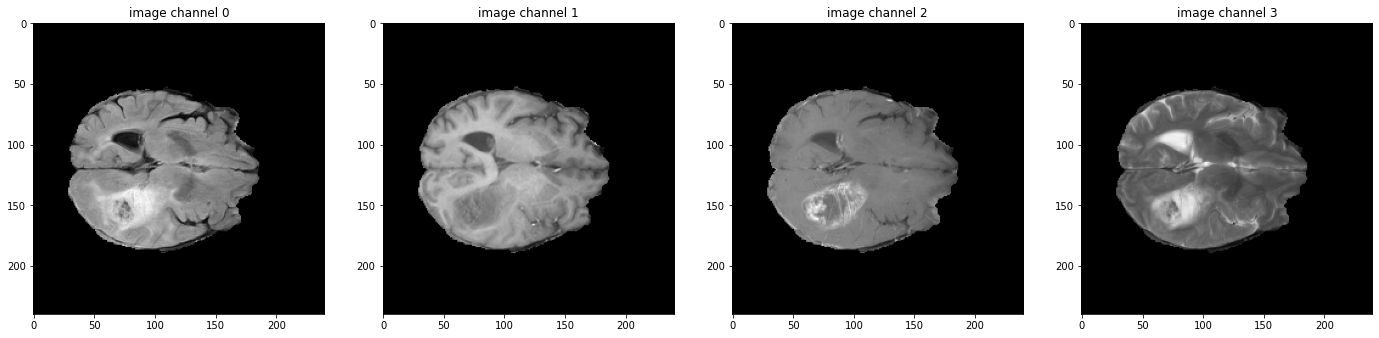

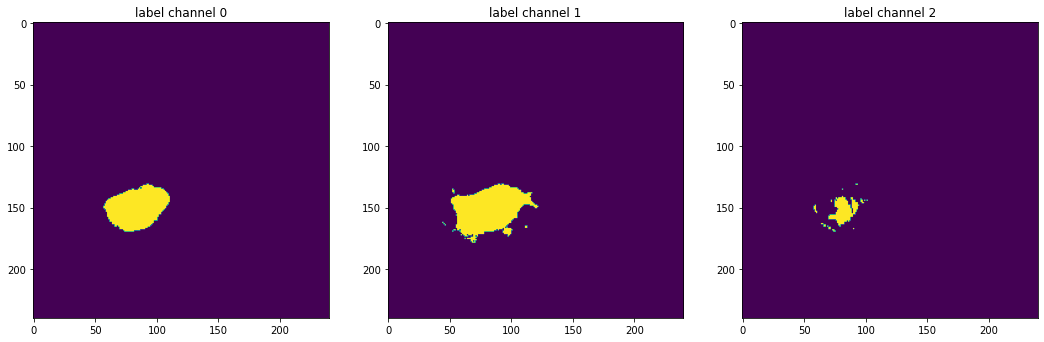

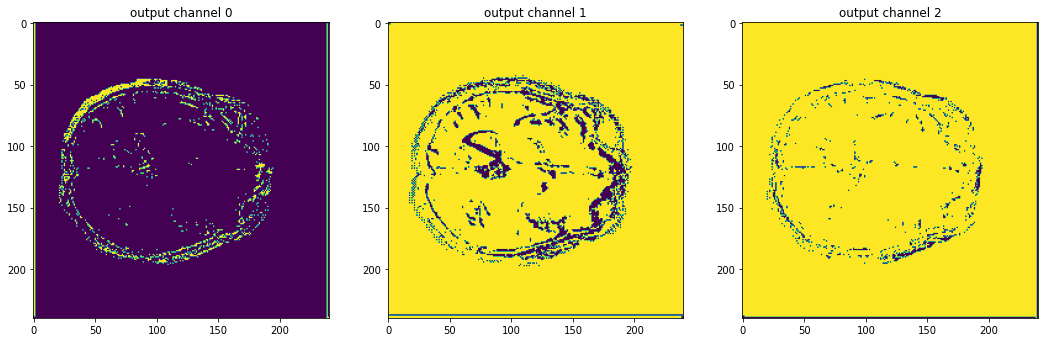

In [14]:
model=Generator()
model.load_state_dict(torch.load("../temp/gan_model.pth"), strict=False)
model.to(device)
# model.to(device)
model.eval()

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[6]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input,model)
    val_output = post_trans(val_output[0])
    
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[6]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[6]["label"][i, :, :, 70].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 70].detach().cpu())
    plt.show()

In [16]:
val_output = inference(val_input,model)
val_output = post_trans(val_output)
dis_output = discriminator(val_output)

In [17]:
dis_output

tensor([[1.]], device='cuda:0', grad_fn=<SigmoidBackward0>)